# Import the needed libraries
- pandas and numpy are used for storing, cleansing, and analyising the finacial records
- yfinance is used for downloading finacial historical data from Yahoo
- threading is used to handle concurrent processing of downloading data with yfinance to boost performance
- logging is used to record long processes progress into a logfile
- matplotlib is used to plot the data on the graph, i.e. visualization of data

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import threading
import logging
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Enable and setup logging

In [3]:
logging.basicConfig(level=logging.INFO, filename='portfolio_builder.log')

# Define the procedures/functions/classes for downloading tickers' information from Yahoo

In [4]:
  
def getValue(info, key):
    if(key in info): 
        return info[key]
    else:
        return np.nan
    
def save2csv(tickersInfo, filename):
    selected_keys= yf.Ticker('msft').info.keys()
    tickersFrame = pd.DataFrame(data=[],columns=selected_keys)

    for t in tickersInfo:
        s={key: getValue(t, key) for key in selected_keys}
        tickersFrame=tickersFrame.append(s, ignore_index=True)

    tickersFrame.set_index(['symbol'], inplace=True)
    tickersFrame.sort_index(inplace=True)
    tickersFrame.to_csv(filename)

class DownloadThread (threading.Thread):
    tickersInfo=[] # all tickers Information downloaded from yahoo accumulated here

    def __init__(self, threadID, name, arange, yftickers):
      threading.Thread.__init__(self)
      self.threadID = threadID
      self.name = name
      self.arange = arange
      self.yftickers=yftickers
        
    def run(self):
      logging.info("Starting " + self.name + ' in ' + str(self.arange))
      self.appendToTickersInfo()
      logging.info("Exiting " + self.name)
    
    def appendToTickersInfo(self):
        for t in self.arange:
            try:
                DownloadThread.tickersInfo.append(self.yftickers.tickers[t].info)
                if (t%100==0): logging.info("Adding tickers[" + str(t) + "]")
            except:
                logging.info("Ticker[" + str(t) + "] is skipped due to yfinance exception.")
                pass
            
def loadTickersInfoFromYahoo(tickersFrame: pd.DataFrame, batchSize: int):
    yftickers=yf.Tickers(tickersFrame.Tickers.to_list())
    logging.info('There are ' + str(len(yftickers.tickers)) + ' tickers to be loaded in background threads.')
    threads = [DownloadThread(i, 'T'+str(i),range(batchSize*i,batchSize*(i+1)),yftickers) 
               for i in range(int(len(yftickers.tickers) / batchSize)+1)]
    DownloadThread.tickersInfo=[]
    for t in threads:
        t.start() # start all threads
    for t in threads:
        t.join() # wait until all threads completed
    logging.info('There are ' + str(len(DownloadThread.tickersInfo)) + ' tickers info downloaded.')
    return DownloadThread.tickersInfo

# Download tickers' information from Yahoo (Take long time > 30 minutes)
- The list of HK tickers, which information is to be downloaded, are specified on HKTickers.csv
- The resulting tickersInfo is then saved on HKTickersInfo.csv
- It takes time to load all information from Yahoo, please be patient
- Due to unknown reason, some tickers may return error from yfinance calls, these tickers will be skipped (review the portfolio_builder.log for details)

In [4]:
batchSize=300  # number of tickers being processed in a thread
hk_tickers=pd.read_csv('HKTickers.csv')
tickersInfo = loadTickersInfoFromYahoo(hk_tickers, batchSize)
save2csv(tickersInfo, 'HKTickersInfo.csv')

# Loading tickers' information from local HKTickersInfo.csv
- To speed up the process, we may start here to process HK Tickers Information

In [5]:
tickersFrame = pd.read_csv('HKTickersInfo.csv')

# Sort out the recommended portfolio (To be implemented)
- sort_values: descending
- Price to Earnings Ratio: the top 500
- Earnings Quarterly Growth: the top 500

- 11 stock from different sectors
- Weights：Price-weighted return

In [105]:
selected_keys=['symbol', 'sector', 'industry', 'longName', 'volume', 
                'profitMargins', 'sharesOutstanding', 'regularMarketPreviousClose', 
                'trailingPE', 'priceToBook', 'earningsQuarterlyGrowth','marketCap']
tickersFrame = pd.read_csv('HKTickersInfo.csv')
# for c in tickersFrame.columns: print(c)
tickersFrame=tickersFrame[selected_keys]
tickersFrame=tickersFrame.dropna()
tickersFrame=tickersFrame.astype({'trailingPE': 'float64'})
tickersFrame.set_index(['sector','symbol'], inplace=True)
tickersFrame.sort_index(inplace=True)

tickersFrame1=tickersFrame[tickersFrame['trailingPE']>0]
tickersFrame1=tickersFrame1.sort_values(by=['trailingPE'], ascending=False).iloc[0:500]

tickersFrame2=tickersFrame[tickersFrame['earningsQuarterlyGrowth']>0]
tickersFrame2=tickersFrame2.sort_values(by=['earningsQuarterlyGrowth'], ascending=False).iloc[0:500]

tickersFrame = pd.merge(tickersFrame1,tickersFrame2,how='inner',on=['sector','symbol']).groupby('sector').head(1)
tickersFrame

,,industry_x,longName_x,volume_x,profitMargins_x,sharesOutstanding_x,regularMarketPreviousClose_x,trailingPE_x,priceToBook_x,earningsQuarterlyGrowth_x,marketCap_x,industry_y,longName_y,volume_y,profitMargins_y,sharesOutstanding_y,regularMarketPreviousClose_y,trailingPE_y,priceToBook_y,earningsQuarterlyGrowth_y,marketCap_y
sector,symbol,,,,,,,,,,,,,,,,,,,,
Financial Services,0139.HK,Capital Markets,Central Wealth Group Holdings Limited,4887000,-0.05677,1.471670e+10,0.053,inf,0.540816,1.415,7.949841e+08,Capital Markets,Central Wealth Group Holdings Limited,4887000,-0.05677,1.471670e+10,0.053,inf,0.540816,1.415,7.949841e+08
Energy,2883.HK,Oil & Gas Equipment & Services,China Oilfield Services Limited,45239978,0.08343,1.811120e+09,10.520,639.724600,9.898990,10.662,7.809484e+10,Oil & Gas Equipment & Services,China Oilfield Services Limited,45239978,0.08343,1.811120e+09,10.520,639.724600,9.898990,10.662,7.809484e+10
Consumer Cyclical,0102.HK,Resorts & Casinos,Summit Ascent Holdings Limited,360000,0.09326,1.803780e+09,1.010,198.039200,1.160919,15.764,1.821818e+09,Resorts & Casinos,Summit Ascent Holdings Limited,360000,0.09326,1.803780e+09,1.010,198.039200,1.160919,15.764,1.821818e+09
Technology,0981.HK,Semiconductors,Semiconductor Manufacturing International Corp...,38529366,0.05629,5.054950e+09,11.140,143.723400,9.214227,3.335,5.631214e+10,Semiconductors,Semiconductor Manufacturing International Corp...,38529366,0.05629,5.054950e+09,11.140,143.723400,9.214227,3.335,5.631214e+10
Healthcare,0455.HK,Drug Manufacturers—Specialty & Generic,Tianda Pharmaceuticals Limited,184000,0.00528,2.150040e+09,0.168,139.999980,0.494118,0.042,3.870082e+08,Drug Manufacturers—Specialty & Generic,Tianda Pharmaceuticals Limited,184000,0.00528,2.150040e+09,0.168,139.999980,0.494118,0.042,3.870082e+08
Consumer Defensive,0291.HK,Beverages—Brewers,China Resources Beer (Holdings) Company Limited,4840451,0.04045,3.244180e+09,41.100,124.421810,46.095444,0.241,1.388836e+11,Beverages—Brewers,China Resources Beer (Holdings) Company Limited,4840451,0.04045,3.244180e+09,41.100,124.421810,46.095444,0.241,1.388836e+11
Industrials,1133.HK,Specialty Industrial Machinery,Harbin Electric Company Limited,1742000,0.00311,6.755710e+08,2.010,44.352715,1.521084,0.022,3.430102e+09,Specialty Industrial Machinery,Harbin Electric Company Limited,1742000,0.00311,6.755710e+08,2.010,44.352715,1.521084,0.022,3.430102e+09
Real Estate,0251.HK,Real Estate—Diversified,S E A Holdings Limited,76000,0.15908,6.622090e+08,7.580,41.758244,0.818524,0.139,5.072939e+09,Real Estate—Diversified,S E A Holdings Limited,76000,0.15908,6.622090e+08,7.580,41.758244,0.818524,0.139,5.072939e+09
Utilities,3633.HK,Utilities—Regulated Gas,Zhongyu Gas Holdings Limited,943000,0.08582,2.537210e+09,6.890,31.221720,3.990746,0.208,1.751372e+10,Utilities—Regulated Gas,Zhongyu Gas Holdings Limited,943000,0.08582,2.537210e+09,6.890,31.221720,3.990746,0.208,1.751372e+10


In [106]:
recommendedPortfolio = tickersFrame.reset_index('sector').index.to_list()
recommendedPortfolio

['0139.HK',
 '2883.HK',
 '0102.HK',
 '0981.HK',
 '0455.HK',
 '0291.HK',
 '1133.HK',
 '0251.HK',
 '3633.HK',
 '0826.HK',
 '0762.HK']

# Gather and calculate the equal weighted portfolio performance

In [107]:
portfolio_history=yf.download(recommendedPortfolio, period='5y')
portfolio_history=portfolio_history.dropna()
portfolio_historical_mean=portfolio_history.mean(axis=1, level=0)

[*********************100%***********************]  11 of 11 completed


# Define procedure to plot the portfolio performance in compare with HSI

In [108]:
def plot2compareHSI(portdata, label):
    hsi=yf.Ticker('^HSI')
    hsidata=hsi.history(period='5y')
    fig=plt.figure()
    fig.set_size_inches(18.5, 10.5)
    plt.plot(hsidata['Close']/hsidata.iloc[0]['Open']-1, linestyle='-', linewidth=1, label='HSI')
    plt.plot(portdata['Close']/portdata.iloc[0]['Open']-1, linestyle='--', linewidth=1, label=label)
    plt.legend()
    plt.show()

# Plot the recommended portfolio performance in compare with HSI

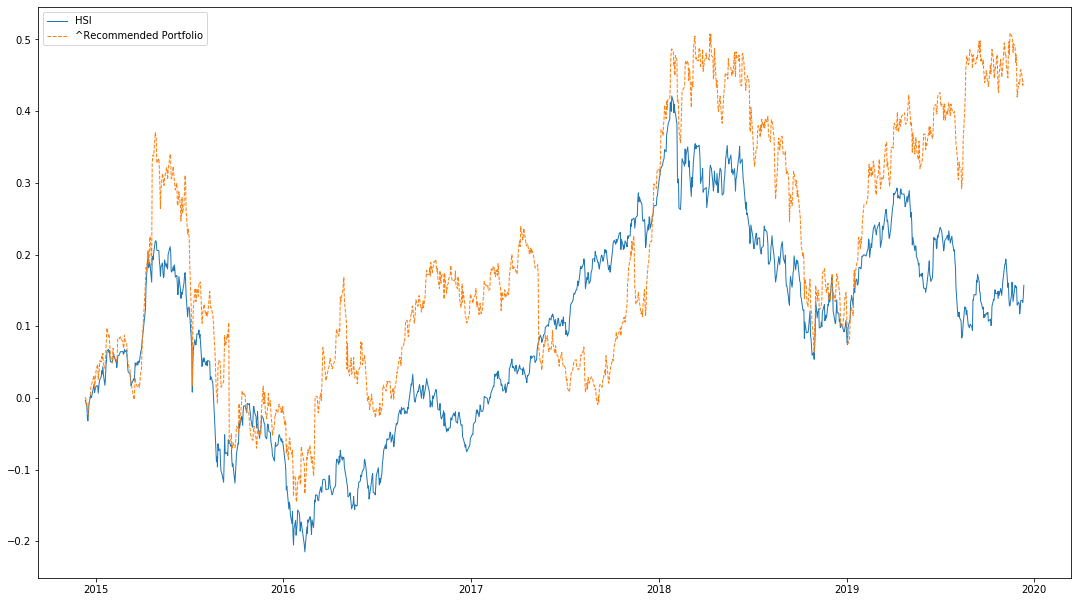

In [109]:
plot2compareHSI(portfolio_historical_mean, '^Recommended Portfolio')